# Peak Load Imputation Methods

In [1]:
# import libraries
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# imputation methods
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from scipy.spatial import distance
from shapely.geometry import MultiPolygon, Polygon, Point
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

### import the datasets

In [2]:
# import split datasets

train_ESA = gpd.read_file('train_ESA.gpkg')
val_ESA = gpd.read_file('val_ESA.gpkg')
test_ESA = gpd.read_file('test_ESA.gpkg')

# Display the rows of the dataframes
print(train_ESA.shape[0])
print(val_ESA.shape[0])
print(test_ESA.shape[0])

3303
708
708


In [3]:
# Function to evaluate the imputation
def evaluate_imputation(original, imputed):
    rmse = np.sqrt(mean_squared_error(original, imputed))
    mae = mean_absolute_error(original, imputed)
    mape = mean_absolute_percentage_error(original+1, imputed)*100 # add 1 to original to avoid -inf
    return rmse, mae, mape

### 1. Mean/Median/Mode imputation

In [4]:
target = 'peakload'
mean_value = train_ESA[target].mean()
median_value = train_ESA[target].median()
mode_value = train_ESA[target].mode().iloc[0]

print("The description in peak load")
print(" ")
print(f"  Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"  Mode: {mode_value}")

The description in peak load
 
  Mean: 95.4077838328792
Median: 53.51
  Mode: 3.9


In [5]:
train_capacity = train_ESA[[target]]
val_capacity = val_ESA[[target]]

# Copy from original val set
val_mean_imputed = val_capacity.copy()
val_median_imputed = val_capacity.copy()
val_mode_imputed = val_capacity.copy()

# Impute with calculated statistics
val_mean_imputed[target] = mean_value
val_median_imputed[target] = median_value
val_mode_imputed[target] = mode_value

rmse_mean, mae_mean, mape_mean = evaluate_imputation(val_capacity, val_mean_imputed[[target]])
rmse_median, mae_median, mape_median = evaluate_imputation(val_capacity, val_median_imputed[[target]])
rmse_mode, mae_mode, mape_mode = evaluate_imputation(val_capacity, val_mode_imputed[[target]])

# Print results
print(f"RMSE (Mean Imputation)  : {rmse_mean}")
print(f"MAE  (Mean Imputation)  : {mae_mean}")
print(f"MAPE (Mean Imputation)  : {mape_mean}")
print(" ")
print(f"RMSE (Median Imputation): {rmse_median}")
print(f"MAE  (Median Imputation): {mae_median}")
print(f"MAPE (Median Imputation): {mape_median}")
print(" ")
print(f"RMSE (Mode Imputation)  : {rmse_mode}")
print(f"MAE  (Mode Imputation)  : {mae_mode}")
print(f"MAPE (Mode Imputation)  : {mape_mode}")

RMSE (Mean Imputation)  : 110.93296524922062
MAE  (Mean Imputation)  : 87.34161186286734
MAPE (Mean Imputation)  : 631.9345627185558
 
RMSE (Median Imputation): 119.02824173967463
MAE  (Median Imputation): 80.7364406779661
MAPE (Median Imputation): 348.7943166825053
 
RMSE (Mode Imputation)  : 144.60875394496048
MAE  (Mode Imputation)  : 93.13104519774011
MAPE (Mode Imputation)  : 81.99645680993332


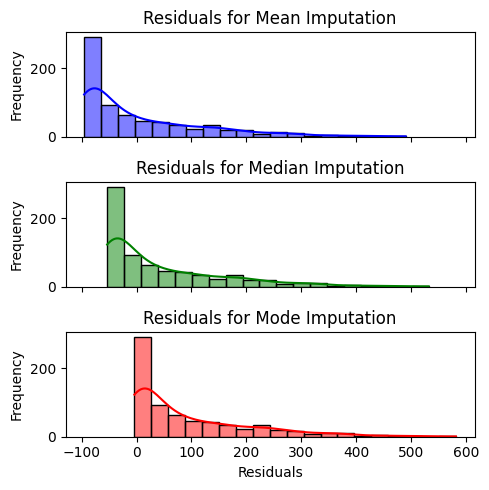

In [6]:
# Calculate residuals
residuals_mean = val_capacity[target] - val_mean_imputed[target]
residuals_median = val_capacity[target] - val_median_imputed[target]
residuals_mode = val_capacity[target] - val_mode_imputed[target]

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(5, 5), sharex=True)

# Mean
sns.histplot(residuals_mean, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Residuals for Mean Imputation')
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')

# Median
sns.histplot(residuals_median, kde=True, color='green', ax=axs[1])
axs[1].set_title('Residuals for Median Imputation')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')

# Mode
sns.histplot(residuals_mode, kde=True, color='red', ax=axs[2])
axs[2].set_title('Residuals for Mode Imputation')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 2. KNN imputation

In [7]:
target = 'peakload'

conti_features = ['Non_Domestic_consumption_building_C', 'Domestic_consumption_building', 'Consumption_postcode', 
                  'Population_building', 'building_density_number', 'All building_num']


In [8]:
# Normalise features
scaler = StandardScaler()
train_conti_scaled = scaler.fit_transform(train_ESA[conti_features])
val_conti_scaled = scaler.transform(val_ESA[conti_features])

# Add the target column
train_scaled_with_target = np.concatenate([train_conti_scaled, train_ESA[[target]].values.reshape(-1, 1)], axis=1)
val_scaled_with_target = np.concatenate([val_conti_scaled, val_ESA[[target]].values.reshape(-1, 1)], axis=1)

# Convert to df
train_scaled_df = pd.DataFrame(train_scaled_with_target, columns=conti_features + [target])
val_scaled_df = pd.DataFrame(val_scaled_with_target, columns=conti_features + [target])

In [9]:
# Citation: Scikit-learn developers, KNNImputer.
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

# Function to perform KNN Imputation
def impute_knn(target, n):
    
    # Prepare the val datasets
    val_scaled_df[target] = np.nan
    
    # KNN imputation
    imputer = KNNImputer(n_neighbors=n)
    imputer.fit(train_scaled_df)
    val_imputed = imputer.transform(val_scaled_df)
    
    return val_imputed

# Apply the KNN imputer
val2_K3 = impute_knn(target, 3)
val2_K5 = impute_knn(target, 5)
val2_K7 = impute_knn(target, 7)
val2_K9 = impute_knn(target, 9)
val2_K11 = impute_knn(target, 11)

# Convert the numpy array back to a DataFrame
val_K3_df = pd.DataFrame(val2_K3, columns=conti_features + [target])
val_K5_df = pd.DataFrame(val2_K5, columns=conti_features + [target])
val_K7_df = pd.DataFrame(val2_K7, columns=conti_features + [target])
val_K9_df = pd.DataFrame(val2_K9, columns=conti_features + [target])
val_K11_df = pd.DataFrame(val2_K11, columns=conti_features + [target])

In [10]:
rmse_k3, mae_k3, mape_k3 = evaluate_imputation(val_ESA[target], val_K3_df[target])
rmse_k5, mae_k5, mape_k5 = evaluate_imputation(val_ESA[target], val_K5_df[target])
rmse_k7, mae_k7, mape_k7 = evaluate_imputation(val_ESA[target], val_K7_df[target])
rmse_k9, mae_k9, mape_k9 = evaluate_imputation(val_ESA[target], val_K9_df[target])
rmse_k11, mae_k11, mape_k11 = evaluate_imputation(val_ESA[target], val_K11_df[target])

# Print results
print(f"RMSE (K=3)  : {rmse_k3}")
print(f"MAE  (K=3)  : {mae_k3}")
print(f"MAPE (K=3)  : {mape_k3}")
print(" ")
print(f"RMSE (K=5)  : {rmse_k5}")
print(f"MAE  (K=5)  : {mae_k5}")
print(f"MAPE (K=5)  : {mape_k5}")
print(" ")
print(f"RMSE (K=7)  : {rmse_k7}")
print(f"MAE  (K=7)  : {mae_k7}")
print(f"MAPE (K=7)  : {mape_k7}")
print(" ")
print(f"RMSE (K=9)  : {rmse_k9}")
print(f"MAE  (K=9)  : {mae_k9}")
print(f"MAPE (K=9)  : {mape_k9}")
print(" ")
print(f"RMSE (K=11) : {rmse_k11}")
print(f"MAE  (K=11) : {mae_k11}")
print(f"MAPE (K=11) : {mape_k11}")

RMSE (K=3)  : 71.58478777738384
MAE  (K=3)  : 44.83042843691149
MAPE (K=3)  : 230.47785443782135
 
RMSE (K=5)  : 67.81375586747211
MAE  (K=5)  : 42.07346610169491
MAPE (K=5)  : 223.4045922233677
 
RMSE (K=7)  : 67.43131141747557
MAE  (K=7)  : 41.865478208232446
MAPE (K=7)  : 227.99604260939455
 
RMSE (K=9)  : 67.49981821769173
MAE  (K=9)  : 41.90419491525424
MAPE (K=9)  : 235.65128437429107
 
RMSE (K=11) : 67.54284310548313
MAE  (K=11) : 42.06110169491526
MAPE (K=11) : 240.6329339366428


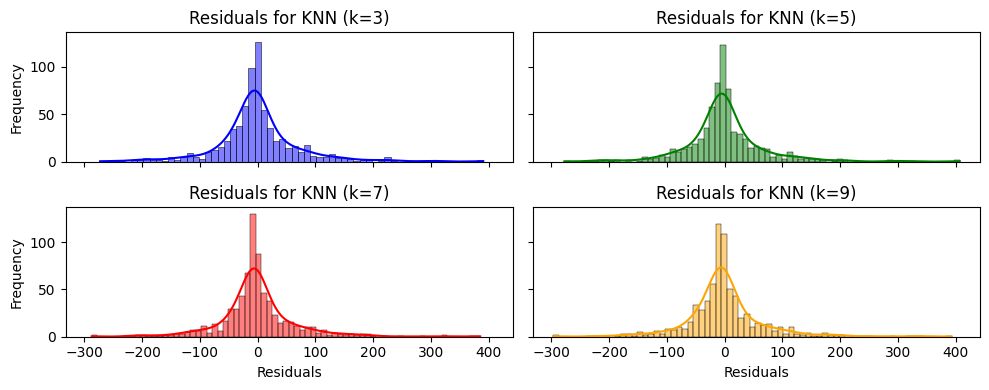

In [11]:
# Calculate residuals
residuals_K3 = val_ESA[target] - val_K3_df[target]
residuals_K5 = val_ESA[target] - val_K5_df[target]
residuals_K7 = val_ESA[target] - val_K7_df[target]
residuals_K9 = val_ESA[target] - val_K9_df[target]
residuals_K11 = val_ESA[target] - val_K11_df[target]

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 4), sharex=True, sharey=True)
axs = ax.flatten()

# k=3
sns.histplot(residuals_K3, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Residuals for KNN (k=3)')
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')

# k=5
sns.histplot(residuals_K5, kde=True, color='green', ax=axs[1])
axs[1].set_title('Residuals for KNN (k=5)')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')

# k=7
sns.histplot(residuals_K7, kde=True, color='red', ax=axs[2])
axs[2].set_title('Residuals for KNN (k=7)')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')

# k=9
sns.histplot(residuals_K9, kde=True, color='orange', ax=axs[3])
axs[3].set_title('Residuals for KNN (k=9)')
axs[3].set_xlabel('Residuals')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 3. Linear regression imputation

In [12]:
# Citation: GeeksforGeeks, Detecting Multicollinearity with VIF in Python. 
# https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

# Check for multicollinearity
df_features = pd.DataFrame(train_ESA, columns=conti_features)
vif = pd.DataFrame()
vif["Variable"] = df_features.columns
vif["VIF"] = [variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]

print(vif)

                              Variable        VIF
0  Non_Domestic_consumption_building_C   1.832562
1        Domestic_consumption_building   2.459996
2                 Consumption_postcode   8.485766
3                  Population_building   1.580534
4              building_density_number   2.559355
5                     All building_num  11.846292


In [13]:
new_features = ['Non_Domestic_consumption_building_C', 'Domestic_consumption_building', 'Consumption_postcode', 
                   'Population_building', 'building_density_number']#, 'All building_num']

# Check again for multicollinearity
df_features = pd.DataFrame(train_ESA, columns=new_features)
vif = pd.DataFrame()
vif["Variable"] = df_features.columns
vif["VIF"] = [variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]

print(vif)

                              Variable       VIF
0  Non_Domestic_consumption_building_C  1.666324
1        Domestic_consumption_building  2.390704
2                 Consumption_postcode  2.899786
3                  Population_building  1.535851
4              building_density_number  2.076258


In [14]:
# Citation: Scikit-learn, Linear Regression Example. 
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

# Train with low VIF features
model2 = LinearRegression()
model2.fit(train_ESA[new_features], train_ESA[[target]])
predictions2 = model2.predict(val_ESA[new_features])

# evaluation metric
rmse_reg2, mae_reg2, mape_reg2 = evaluate_imputation(val_ESA[target], predictions2)

# Print results
print(f"RMSE (Regression Imputation): {rmse_reg2}")
print(f"MAE  (Regression Imputation): {mae_reg2}")
print(f"MAPE (Regression Imputation): {mape_reg2}")

RMSE (Regression Imputation): 71.76379501884819
MAE  (Regression Imputation): 47.274499196116075
MAPE (Regression Imputation): 304.67156039733385


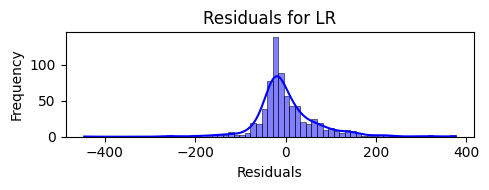

In [15]:
# Calculate residuals
residuals_LR = val_ESA[target] - predictions2.ravel()

# Plot residuals
fig, ax = plt.subplots(figsize=(5, 2))

sns.histplot(residuals_LR, kde=True, color='blue', ax=ax)
ax.set_title('Residuals for LR')
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 4. RF imputation

In [16]:
# Citation: Scikit-learn, RandomForestRegressor. 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# Prepare X, y
X_train = train_ESA[conti_features]
y_train = train_ESA[target]
X_val = val_ESA[conti_features]

# perform random forests
rf10_15 = RandomForestRegressor(n_estimators=10, max_depth=15, random_state=24)
rf10_15.fit(X_train, y_train)
y_pred_rf10_15 = rf10_15.predict(X_val)

rf10_30 = RandomForestRegressor(n_estimators=10, max_depth=30, random_state=24)
rf10_30.fit(X_train, y_train)
y_pred_rf10_30 = rf10_30.predict(X_val)

rf100_15 = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=24)
rf100_15.fit(X_train, y_train)
y_pred_rf100_15 = rf100_15.predict(X_val)

rf100_30 = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=24)
rf100_30.fit(X_train, y_train)
y_pred_rf100_30 = rf100_30.predict(X_val)

rf500_15 = RandomForestRegressor(n_estimators=500, max_depth=15, random_state=24)
rf500_15.fit(X_train, y_train)
y_pred_rf500_15 = rf500_15.predict(X_val)

rf500_30 = RandomForestRegressor(n_estimators=500, max_depth=30, random_state=24)
rf500_30.fit(X_train, y_train)
y_pred_rf500_30 = rf500_30.predict(X_val)

In [17]:
rmse_rf10_15, mae_rf10_15, mape_rf10_15 = evaluate_imputation(val_ESA[target], y_pred_rf10_15)
rmse_rf10_30, mae_rf10_30, mape_rf10_30 = evaluate_imputation(val_ESA[target], y_pred_rf10_30)
rmse_rf100_15, mae_rf100_15, mape_rf100_15 = evaluate_imputation(val_ESA[target], y_pred_rf100_15)
rmse_rf100_30, mae_rf100_30, mape_rf100_30 = evaluate_imputation(val_ESA[target], y_pred_rf100_30)
rmse_rf500_15, mae_rf500_15, mape_rf500_15 = evaluate_imputation(val_ESA[target], y_pred_rf500_15)
rmse_rf500_30, mae_rf500_30, mape_rf500_30 = evaluate_imputation(val_ESA[target], y_pred_rf500_30)

# Print results
print(f"RMSE (rf10_15)  : {rmse_rf10_15}")
print(f"MAE  (rf10_15)  : {mae_rf10_15}")
print(f"MAPE (rf10_15)  : {mape_rf10_15}")
print(" ")
print(f"RMSE (rf10_30)  : {rmse_rf10_30}")
print(f"MAE  (rf10_30)  : {mae_rf10_30}")
print(f"MAPE (rf10_30)  : {mape_rf10_30}")
print(" ")
print(f"RMSE (rf100_15)  : {rmse_rf100_15}")
print(f"MAE  (rf100_15)  : {mae_rf100_15}")
print(f"MAPE (rf100_15)  : {mape_rf100_15}")
print(" ")
print(f"RMSE (rf100_30)  : {rmse_rf100_30}")
print(f"MAE  (rf100_30)  : {mae_rf100_30}")
print(f"MAPE (rf100_30)  : {mape_rf100_30}")
print(" ")
print(f"RMSE (rf500_15)  : {rmse_rf500_15}")
print(f"MAE  (rf500_15)  : {mae_rf500_15}")
print(f"MAPE (rf500_15)  : {mape_rf500_15}")
print(" ")
print(f"RMSE (rf500_30)  : {rmse_rf500_30}")
print(f"MAE  (rf500_30)  : {mae_rf500_30}")
print(f"MAPE (rf500_30)  : {mape_rf500_30}")

RMSE (rf10_15)  : 72.65408179776092
MAE  (rf10_15)  : 44.65305048643165
MAPE (rf10_15)  : 242.26348876482842
 
RMSE (rf10_30)  : 73.6258738665539
MAE  (rf10_30)  : 45.900267172137504
MAPE (rf10_30)  : 240.27673423133803
 
RMSE (rf100_15)  : 69.38984682487144
MAE  (rf100_15)  : 43.32789417680006
MAPE (rf100_15)  : 224.05121552226626
 
RMSE (rf100_30)  : 69.15357585384521
MAE  (rf100_30)  : 43.35037847328343
MAPE (rf100_30)  : 225.10082060353818
 
RMSE (rf500_15)  : 69.28598867919017
MAE  (rf500_15)  : 43.286712631945186
MAPE (rf500_15)  : 226.21295569399206
 
RMSE (rf500_30)  : 69.32958836909783
MAE  (rf500_30)  : 43.47965492231251
MAPE (rf500_30)  : 226.45898262937175


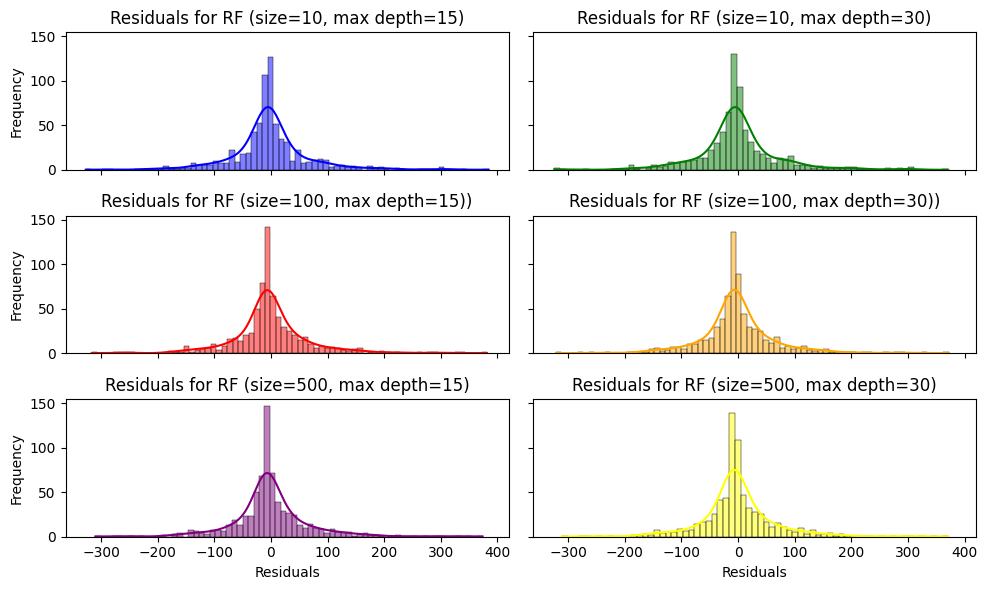

In [18]:
# Calculate residuals
residuals_rf10_15 = val_ESA[target] - y_pred_rf10_15
residuals_rf10_30 = val_ESA[target] - y_pred_rf10_30
residuals_rf100_15 = val_ESA[target] - y_pred_rf100_15
residuals_rf100_30 = val_ESA[target] - y_pred_rf100_30
residuals_rf500_15 = val_ESA[target] - y_pred_rf500_15
residuals_rf500_30 = val_ESA[target] - y_pred_rf500_30

# Create subplots
fig, ax = plt.subplots(3, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = ax.flatten()

# n_estimators=10
sns.histplot(residuals_rf10_15, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Residuals for RF (size=10, max depth=15)')
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')

sns.histplot(residuals_rf10_30, kde=True, color='green', ax=axs[1])
axs[1].set_title('Residuals for RF (size=10, max depth=30)')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')

# n_estimators=100
sns.histplot(residuals_rf100_15, kde=True, color='red', ax=axs[2])
axs[2].set_title('Residuals for RF (size=100, max depth=15))')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')

sns.histplot(residuals_rf100_30, kde=True, color='orange', ax=axs[3])
axs[3].set_title('Residuals for RF (size=100, max depth=30))')
axs[3].set_xlabel('Residuals')
axs[3].set_ylabel('Frequency')

# n_estimators=500
sns.histplot(residuals_rf500_15, kde=True, color='purple', ax=axs[4])
axs[4].set_title('Residuals for RF (size=500, max depth=15)')
axs[4].set_xlabel('Residuals')
axs[4].set_ylabel('Frequency')

sns.histplot(residuals_rf500_30, kde=True, color='yellow', ax=axs[5])
axs[5].set_title('Residuals for RF (size=500, max depth=30)')
axs[5].set_xlabel('Residuals')
axs[5].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 5. MLP imputation

In [19]:
# Normalise target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(train_ESA[[target]])

# Normalize continuous features
scaler_X = StandardScaler()
train_conti_scaled = scaler_X.fit_transform(train_ESA[conti_features])
val_conti_scaled = scaler_X.transform(val_ESA[conti_features])

In [20]:
# Citation: Scikit-learn, MLPRegressor. 
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

# Function to perform MLP Imputation
def impute_mlp_N(hiddensizes, lr):
    
    mlp = MLPRegressor(hidden_layer_sizes=hiddensizes, activation='relu', solver='adam', 
                       max_iter=1000, random_state=363, early_stopping=True, validation_fraction=0.1, 
                       learning_rate_init=lr)
    
    # Train the model
    mlp.fit(train_conti_scaled, y_train_scaled.ravel())
    
    # Predict on test data
    y_pred_scaled = mlp.predict(val_conti_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    return y_pred

# Different settings
mlp_setting = [
    ((5, 5), 0.005),
    ((5, 5), 0.01),
    ((5, 5), 0.05),
    ((5, 5), 0.1),
    ((15, 15), 0.005),
    ((15, 15), 0.01),
    ((15, 15), 0.05),
    ((15, 15), 0.1),
    ((30, 30), 0.005),
    ((30, 30), 0.01),
    ((30, 30), 0.05),
    ((30, 30), 0.1),
]

results = {}

# Apply MLP and evaluate
for setting in mlp_setting:
    hiddensizes, lr = setting
    imputed_values = impute_mlp_N(hiddensizes, lr)
    rmse, mae, mape = evaluate_imputation(val_ESA[[target]], imputed_values)
    results[setting] = (rmse, mae, mape)

# Print the results
for setting, (rmse, mae, mape) in results.items():
    hiddensizes, lr = setting
    print(f"Hidden Sizes {hiddensizes}, lr {lr}:")
    print(f"  RMSE : {rmse:.2f}")
    print(f"  MAE  : {mae:.2f}")
    print(f"  MAPE : {mape:.2f}%")
    print(" ")

Hidden Sizes (5, 5), lr 0.005:
  RMSE : 68.68
  MAE  : 41.48
  MAPE : 208.34%
 
Hidden Sizes (5, 5), lr 0.01:
  RMSE : 68.95
  MAE  : 42.12
  MAPE : 222.06%
 
Hidden Sizes (5, 5), lr 0.05:
  RMSE : 67.71
  MAE  : 40.75
  MAPE : 182.85%
 
Hidden Sizes (5, 5), lr 0.1:
  RMSE : 68.04
  MAE  : 41.99
  MAPE : 218.59%
 
Hidden Sizes (15, 15), lr 0.005:
  RMSE : 67.13
  MAE  : 42.26
  MAPE : 234.43%
 
Hidden Sizes (15, 15), lr 0.01:
  RMSE : 67.42
  MAE  : 42.80
  MAPE : 244.91%
 
Hidden Sizes (15, 15), lr 0.05:
  RMSE : 68.06
  MAE  : 43.26
  MAPE : 240.66%
 
Hidden Sizes (15, 15), lr 0.1:
  RMSE : 68.43
  MAE  : 42.32
  MAPE : 227.52%
 
Hidden Sizes (30, 30), lr 0.005:
  RMSE : 66.14
  MAE  : 42.13
  MAPE : 259.56%
 
Hidden Sizes (30, 30), lr 0.01:
  RMSE : 66.39
  MAE  : 43.67
  MAPE : 279.84%
 
Hidden Sizes (30, 30), lr 0.05:
  RMSE : 66.93
  MAE  : 41.59
  MAPE : 231.72%
 
Hidden Sizes (30, 30), lr 0.1:
  RMSE : 67.93
  MAE  : 43.48
  MAPE : 265.75%
 


### 6. IDW imputation

In [21]:
# Extract centroids and values for training data
train_centroids = train_ESA['geometry'].apply(lambda geom: geom.centroid)

train_x = [centroid.x for centroid in train_centroids]
train_y = [centroid.y for centroid in train_centroids]
train_target = train_ESA[target]

# Extract centroids and values for validation data
val_centroids = val_ESA['geometry'].apply(lambda geom: geom.centroid)

val_x = [centroid.x for centroid in val_centroids]
val_y = [centroid.y for centroid in val_centroids]
val_target = val_ESA[target]

In [22]:
# Citation: Pareekshith Katti, "Inverse Distance Weighting Interpolation in Python," Medium, 
# https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

def idw_interpolation(x, y, z, xi, yi, power=2):
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    xi = np.asarray(xi)
    yi = np.asarray(yi)
    
    zi = np.zeros_like(xi)
    
    for i in range(len(xi)):
        dists = distance.cdist([(xi[i], yi[i])], list(zip(x, y)), 'euclidean')[0]
        if np.any(dists == 0):
            zi[i] = z[dists == 0][0]
        else:
            weights = 1 / dists**power
            weights /= weights.sum()
            zi[i] = np.dot(weights, z)
    
    return zi

# try different power with all data points
idw_pred_1 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, 1)
idw_pred_2 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, 2)
idw_pred_3 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, 3)

rmse_idw1, mae_idw1, mape_idw1 = evaluate_imputation(val_ESA[target], idw_pred_1)
rmse_idw2, mae_idw2, mape_idw2 = evaluate_imputation(val_ESA[target], idw_pred_2)
rmse_idw3, mae_idw3, mape_idw3 = evaluate_imputation(val_ESA[target], idw_pred_3)

# Print results
print(f"RMSE (IDW 1)  : {rmse_idw1}")
print(f"MAE  (IDW 1)  : {mae_idw1}")
print(f"MAPE (IDW 1)  : {mape_idw1}")
print(" ")
print(f"RMSE (IDW 2)  : {rmse_idw2}")
print(f"MAE  (IDW 2)  : {mae_idw2}")
print(f"MAPE (IDW 2)  : {mape_idw2}")
print(" ")
print(f"RMSE (IDW 3)  : {rmse_idw3}")
print(f"MAE  (IDW 3)  : {mae_idw3}")
print(f"MAPE (IDW 3)  : {mape_idw3}")

RMSE (IDW 1)  : 104.03504440690098
MAE  (IDW 1)  : 83.14393258089433
MAPE (IDW 1)  : 637.1028019908983
 
RMSE (IDW 2)  : 92.97534318621527
MAE  (IDW 2)  : 72.06910760100394
MAPE (IDW 2)  : 560.7897263162135
 
RMSE (IDW 3)  : 92.92946604504728
MAE  (IDW 3)  : 67.83533454091166
MAPE (IDW 3)  : 483.2685929772194


In [23]:
def idw_interpolation(x, y, z, xi, yi, power=2, n_neighbors=None):
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    xi = np.asarray(xi)
    yi = np.asarray(yi)
    
    zi = np.zeros_like(xi)
    
    for i in range(len(xi)):
        # Calculate distances
        dists = distance.cdist([(xi[i], yi[i])], list(zip(x, y)), 'euclidean')[0]
        
        # Sort distances and select the nearest neighbours
        if n_neighbors is not None:
            idx = np.argsort(dists)[:n_neighbors]
            dists = dists[idx]
            z_subset = z[idx]
        else:
            z_subset = z
        
        # Handle cases
        if np.any(dists == 0):
            zi[i] = z_subset[dists == 0][0]
        else:
            weights = 1 / dists**power
            weights /= weights.sum()
            zi[i] = np.dot(weights, z_subset)
    
    return zi

# different number of power and nearest neighbours
n_neighbors = 3
idw_pred_1_3 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=1, n_neighbors=n_neighbors)
idw_pred_2_3 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=2, n_neighbors=n_neighbors)
idw_pred_3_3 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=3, n_neighbors=n_neighbors)

n_neighbors = 5
idw_pred_1_5 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=1, n_neighbors=n_neighbors)
idw_pred_2_5 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=2, n_neighbors=n_neighbors)
idw_pred_3_5 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=3, n_neighbors=n_neighbors)

n_neighbors = 7
idw_pred_1_7 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=1, n_neighbors=n_neighbors)
idw_pred_2_7 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=2, n_neighbors=n_neighbors)
idw_pred_3_7 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=3, n_neighbors=n_neighbors)

n_neighbors = 9
idw_pred_1_9 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=1, n_neighbors=n_neighbors)
idw_pred_2_9 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=2, n_neighbors=n_neighbors)
idw_pred_3_9 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=3, n_neighbors=n_neighbors)

n_neighbors = 11
idw_pred_1_11 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=1, n_neighbors=n_neighbors)
idw_pred_2_11 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=2, n_neighbors=n_neighbors)
idw_pred_3_11 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=3, n_neighbors=n_neighbors)

In [24]:
rmse_idw13, mae_idw13, mape_idw13 = evaluate_imputation(val_ESA[target], idw_pred_1_3)
rmse_idw23, mae_idw23, mape_idw23 = evaluate_imputation(val_ESA[target], idw_pred_2_3)
rmse_idw33, mae_idw33, mape_idw33 = evaluate_imputation(val_ESA[target], idw_pred_3_3)

rmse_idw15, mae_idw15, mape_idw15 = evaluate_imputation(val_ESA[target], idw_pred_1_5)
rmse_idw25, mae_idw25, mape_idw25 = evaluate_imputation(val_ESA[target], idw_pred_2_5)
rmse_idw35, mae_idw35, mape_idw35 = evaluate_imputation(val_ESA[target], idw_pred_3_5)

rmse_idw17, mae_idw17, mape_idw17 = evaluate_imputation(val_ESA[target], idw_pred_1_7)
rmse_idw27, mae_idw27, mape_idw27 = evaluate_imputation(val_ESA[target], idw_pred_2_7)
rmse_idw37, mae_idw37, mape_idw37 = evaluate_imputation(val_ESA[target], idw_pred_3_7)

rmse_idw19, mae_idw19, mape_idw19 = evaluate_imputation(val_ESA[target], idw_pred_1_9)
rmse_idw29, mae_idw29, mape_idw29 = evaluate_imputation(val_ESA[target], idw_pred_2_9)
rmse_idw39, mae_idw39, mape_idw39 = evaluate_imputation(val_ESA[target], idw_pred_3_9)

rmse_idw111, mae_idw111, mape_idw111 = evaluate_imputation(val_ESA[target], idw_pred_1_11)
rmse_idw211, mae_idw211, mape_idw211 = evaluate_imputation(val_ESA[target], idw_pred_2_11)
rmse_idw311, mae_idw311, mape_idw311 = evaluate_imputation(val_ESA[target], idw_pred_3_11)

# Print results
print(f"RMSE (IDW 1,3)  : {rmse_idw13}")
print(f"MAE  (IDW 1,3)  : {mae_idw13}")
print(f"MAPE (IDW 1,3)  : {mape_idw13}")
print(" ")
print(f"RMSE (IDW 2,3)  : {rmse_idw23}")
print(f"MAE  (IDW 2,3)  : {mae_idw23}")
print(f"MAPE (IDW 2,3)  : {mape_idw23}")
print(" ")
print(f"RMSE (IDW 3,3)  : {rmse_idw33}")
print(f"MAE  (IDW 3,3)  : {mae_idw33}")
print(f"MAPE (IDW 3,3)  : {mape_idw33}")
print(" ")
print(f"RMSE (IDW 1,5)  : {rmse_idw15}")
print(f"MAE  (IDW 1,5)  : {mae_idw15}")
print(f"MAPE (IDW 1,5)  : {mape_idw15}")
print(" ")
print(f"RMSE (IDW 2,5)  : {rmse_idw25}")
print(f"MAE  (IDW 2,5)  : {mae_idw25}")
print(f"MAPE (IDW 2,5)  : {mape_idw25}")
print(" ")
print(f"RMSE (IDW 3,5)  : {rmse_idw35}")
print(f"MAE  (IDW 3,5)  : {mae_idw35}")
print(f"MAPE (IDW 3,5)  : {mape_idw35}")
print(" ")
print(f"RMSE (IDW 1,7)  : {rmse_idw17}")
print(f"MAE  (IDW 1,7)  : {mae_idw17}")
print(f"MAPE (IDW 1,7)  : {mape_idw17}")
print(" ")
print(f"RMSE (IDW 2,7)  : {rmse_idw27}")
print(f"MAE  (IDW 2,7)  : {mae_idw27}")
print(f"MAPE (IDW 2,7)  : {mape_idw37}")
print(" ")
print(f"RMSE (IDW 3,7)  : {rmse_idw37}")
print(f"MAE  (IDW 3,7)  : {mae_idw37}")
print(f"MAPE (IDW 3,7)  : {mape_idw37}")
print(" ")
print(f"RMSE (IDW 1,9)  : {rmse_idw19}")
print(f"MAE  (IDW 1,9)  : {mae_idw19}")
print(f"MAPE (IDW 1,9)  : {mape_idw19}")
print(" ")
print(f"RMSE (IDW 2,9)  : {rmse_idw29}")
print(f"MAE  (IDW 2,9)  : {mae_idw29}")
print(f"MAPE (IDW 2,9)  : {mape_idw39}")
print(" ")
print(f"RMSE (IDW 3,9)  : {rmse_idw39}")
print(f"MAE  (IDW 3,9)  : {mae_idw39}")
print(f"MAPE (IDW 3,9)  : {mape_idw39}")
print(" ")
print(f"RMSE (IDW 1,11) : {rmse_idw111}")
print(f"MAE  (IDW 1,11) : {mae_idw111}")
print(f"MAPE (IDW 1,11) : {mape_idw111}")
print(" ")
print(f"RMSE (IDW 2,11) : {rmse_idw211}")
print(f"MAE  (IDW 2,11) : {mae_idw211}")
print(f"MAPE (IDW 2,11) : {mape_idw311}")
print(" ")
print(f"RMSE (IDW 3,11) : {rmse_idw311}")
print(f"MAE  (IDW 3,11) : {mae_idw311}")
print(f"MAPE (IDW 3,11) : {mape_idw311}")

RMSE (IDW 1,3)  : 97.39482323841668
MAE  (IDW 1,3)  : 67.18289044251166
MAPE (IDW 1,3)  : 447.37865287814583
 
RMSE (IDW 2,3)  : 99.05714908525532
MAE  (IDW 2,3)  : 68.08057908304124
MAPE (IDW 2,3)  : 454.813948251718
 
RMSE (IDW 3,3)  : 101.05879925264819
MAE  (IDW 3,3)  : 69.00974101570793
MAPE (IDW 3,3)  : 461.9257261624338
 
RMSE (IDW 1,5)  : 91.49419471559725
MAE  (IDW 1,5)  : 65.2353431094824
MAPE (IDW 1,5)  : 434.28206434112894
 
RMSE (IDW 2,5)  : 93.6394459088174
MAE  (IDW 2,5)  : 66.15330944329719
MAPE (IDW 2,5)  : 439.0678120112427
 
RMSE (IDW 3,5)  : 96.5742850723157
MAE  (IDW 3,5)  : 67.42030061021215
MAPE (IDW 3,5)  : 447.34167500878925
 
RMSE (IDW 1,7)  : 90.0184333276859
MAE  (IDW 1,7)  : 64.92250869215094
MAPE (IDW 1,7)  : 445.9153374668504
 
RMSE (IDW 2,7)  : 91.70323806096069
MAE  (IDW 2,7)  : 65.46325757745433
MAPE (IDW 2,7)  : 447.0576501053732
 
RMSE (IDW 3,7)  : 94.79492381174195
MAE  (IDW 3,7)  : 66.71151409418736
MAPE (IDW 3,7)  : 447.0576501053732
 
RMSE (IDW 1

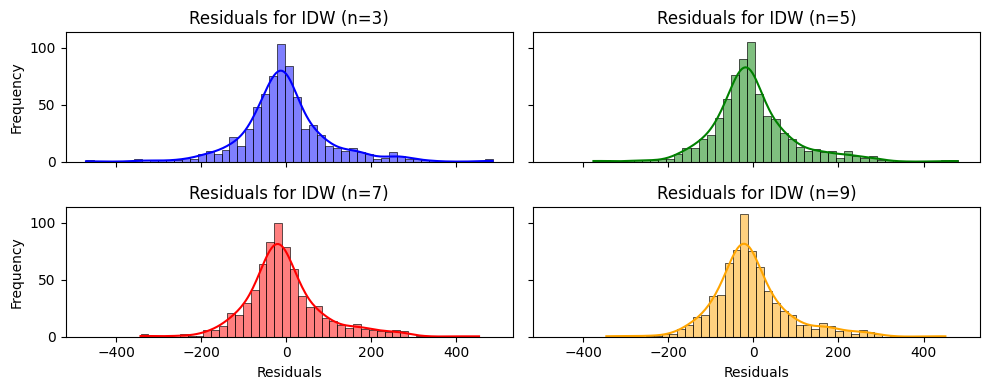

In [25]:
# Calculate residuals
#residuals_idw2 = val_ESA[target] - idw_pred_2
residuals_idw23 = val_ESA[target] - idw_pred_2_3
residuals_idw25 = val_ESA[target] - idw_pred_2_5
residuals_idw27 = val_ESA[target] - idw_pred_2_7
residuals_idw29 = val_ESA[target] - idw_pred_2_9
#residuals_idw211 = val_ESA[target] - idw_pred_2_11

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 4), sharex=True, sharey=True)
axs = ax.flatten()

# n=3, p=2
sns.histplot(residuals_idw23, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Residuals for IDW (n=3)')
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')

# n=5, p=2
sns.histplot(residuals_idw25, kde=True, color='green', ax=axs[1])
axs[1].set_title('Residuals for IDW (n=5)')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')

# n=7, p=2
sns.histplot(residuals_idw27, kde=True, color='red', ax=axs[2])
axs[2].set_title('Residuals for IDW (n=7)')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')

# n=9, p=2
sns.histplot(residuals_idw29, kde=True, color='orange', ax=axs[3])
axs[3].set_title('Residuals for IDW (n=9)')
axs[3].set_xlabel('Residuals')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

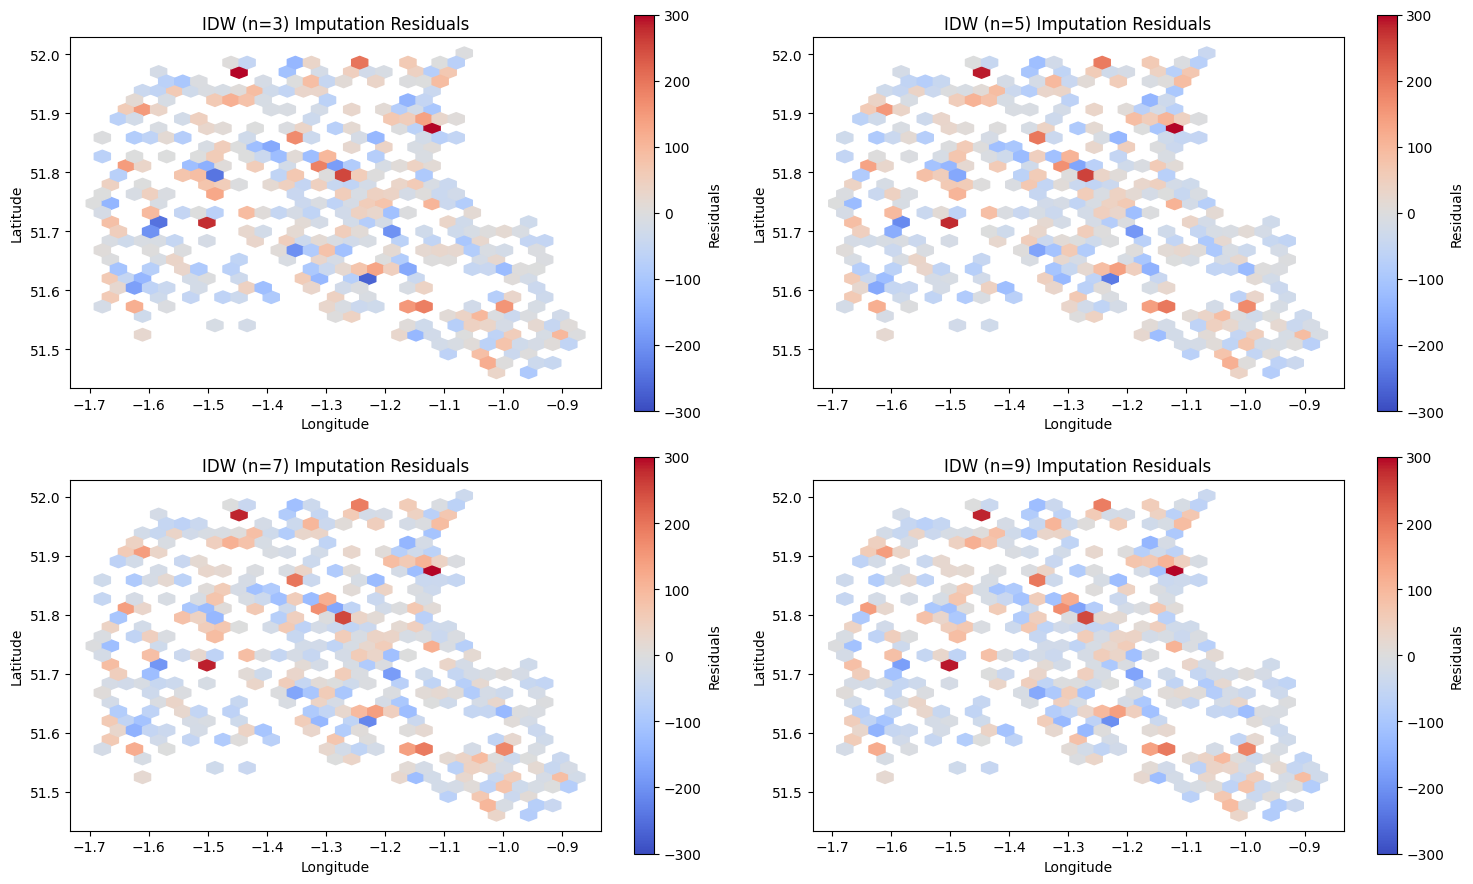

In [26]:
# mapping the residuals
val_ESA['residual_IDW23'] = val_ESA[target] - idw_pred_2_3
val_ESA['residual_IDW25'] = val_ESA[target] - idw_pred_2_5
val_ESA['residual_IDW27'] = val_ESA[target] - idw_pred_2_7
val_ESA['residual_IDW29'] = val_ESA[target] - idw_pred_2_9

# Extract centroids and get the x and y coordinates
val_centroids = val_ESA['geometry'].apply(lambda geom: geom.centroid)
x = [centroid.x for centroid in val_centroids]
y = [centroid.y for centroid in val_centroids]

# Citation: Matplotlib, Axes.hexbin. 
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.hexbin.html

# Create subplots for hexbin plots
fig, axes = plt.subplots(2, 2, figsize=(15, 9), facecolor='white')
cmap='coolwarm'

vmin = -300
vmax = 300

# n=3, p=2
hb_idw2 = axes[0, 0].hexbin(x, y, C=val_ESA['residual_IDW23'], gridsize=30, cmap=cmap, mincnt=1,
                            vmin=vmin, vmax=vmax)
axes[0, 0].set_title('IDW (n=3) Imputation Residuals')
axes[0, 0].set_aspect('equal', adjustable='box')
axes[0, 0].set_xlabel('Longitude')
axes[0, 0].set_ylabel('Latitude')

# n=5, p=2
hb_idw23 = axes[0, 1].hexbin(x, y, C=val_ESA['residual_IDW25'], gridsize=30, cmap=cmap, mincnt=1,
                            vmin=vmin, vmax=vmax)
axes[0, 1].set_title('IDW (n=5) Imputation Residuals')
axes[0, 1].set_aspect('equal', adjustable='box')
axes[0, 1].set_xlabel('Longitude')
axes[0, 1].set_ylabel('Latitude')

# n=7, p=2
hb_idw27 = axes[1, 0].hexbin(x, y, C=val_ESA['residual_IDW27'], gridsize=30, cmap=cmap, mincnt=1,
                            vmin=vmin, vmax=vmax)
axes[1, 0].set_title('IDW (n=7) Imputation Residuals')
axes[1, 0].set_aspect('equal', adjustable='box')
axes[1, 0].set_xlabel('Longitude')
axes[1, 0].set_ylabel('Latitude')

# n=9, p=2
hb_idw29 = axes[1, 1].hexbin(x, y, C=val_ESA['residual_IDW29'], gridsize=30, cmap=cmap, mincnt=1,
                            vmin=vmin, vmax=vmax)
axes[1, 1].set_title('IDW (n=9) Imputation Residuals')
axes[1, 1].set_aspect('equal', adjustable='box')
axes[1, 1].set_xlabel('Longitude')
axes[1, 1].set_ylabel('Latitude')

# Add colorbars
fig.colorbar(hb_idw2, ax=axes[0, 0], label='Residuals')
fig.colorbar(hb_idw23, ax=axes[0, 1], label='Residuals')
fig.colorbar(hb_idw27, ax=axes[1, 0], label='Residuals')
fig.colorbar(hb_idw29, ax=axes[1, 1], label='Residuals')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### 7. GWR imputation

In [27]:
# Citation: MGWR, GWR. 
# https://mgwr.readthedocs.io/en/latest/generated/mgwr.gwr.GWR.html

# Extract centroids and values for training data
train_centroids = train_ESA['geometry'].apply(lambda geom: geom.centroid)

train_coord_x = [centroid.x for centroid in train_centroids]
train_coord_y = [centroid.y for centroid in train_centroids]
train_coords = np.column_stack([train_coord_x, train_coord_y])
train_target = train_ESA[target].values.reshape((-1, 1))
train_features = train_ESA[conti_features].values

# Extract centroids and values for validation data
val_centroids = val_ESA['geometry'].apply(lambda geom: geom.centroid)

val_coord_x = [centroid.x for centroid in val_centroids]
val_coord_y = [centroid.y for centroid in val_centroids]
val_coords = np.column_stack([val_coord_x, val_coord_y])
val_target = val_ESA[target].values.reshape((-1, 1))
val_features = val_ESA[conti_features].values

In [28]:
# Define the list of bandwidth values
bandwidth_values = [50, 100, 200, 400]

# store results
results = {}

# Test each bandwidth with validation set
for bw in bandwidth_values:
    
    # Fit GWR model
    gwr_model = GWR(train_coords, train_target, train_features, bw=bw)
    gwr_results = gwr_model.fit()
    
    # predict for val set
    val_gwr_results = gwr_model.predict(val_coords, val_features)
    val_predictions = val_gwr_results.predictions.flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_ESA[target], val_predictions))
    mae  = mean_absolute_error(val_ESA[target], val_predictions)
    mape = mean_absolute_percentage_error(val_ESA[target]+1, val_predictions)*100
    
    # Store results
    results[bw] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    # Store residuals for plotting
    val_ESA[f'residual_GWR{bw}'] = val_ESA[target] - val_predictions

# Print the results
for bw, metrics in results.items():
    print(f"Bandwidth: {bw}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAE: {metrics['MAE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")

Bandwidth: 50
  RMSE: 84.91
  MAE: 50.13
  MAPE: 259.00%
Bandwidth: 100
  RMSE: 74.53
  MAE: 45.69
  MAPE: 253.49%
Bandwidth: 200
  RMSE: 70.29
  MAE: 43.72
  MAPE: 250.89%
Bandwidth: 400
  RMSE: 70.14
  MAE: 43.83
  MAPE: 256.84%


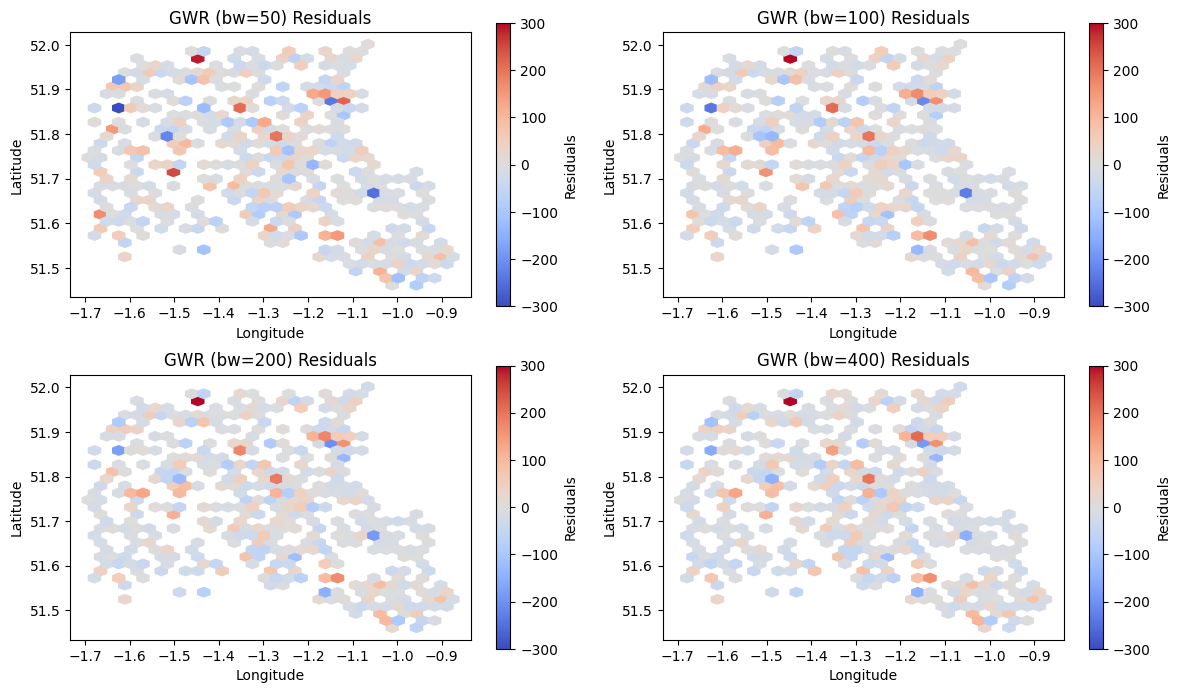

In [29]:
# Extract centroids and get the x and y coordinates
val_centroids = val_ESA['geometry'].apply(lambda geom: geom.centroid)
x = [centroid.x for centroid in val_centroids]
y = [centroid.y for centroid in val_centroids]

# Create subplots for hexbn plots
fig, axes = plt.subplots(2, 2, figsize=(12, 7), facecolor='white')
cmap = 'coolwarm'
vmin = -300
vmax = 300

# Plot hexbin for each bandwidth residuals
for i, bw in enumerate(bandwidth_values):
    ax = axes[i // 2, i % 2]
    hb = ax.hexbin(x, y, C=val_ESA[f'residual_GWR{bw}'], gridsize=30, cmap=cmap, mincnt=1,
                   vmin=vmin, vmax=vmax)
    ax.set_title(f'GWR (bw={bw}) Residuals')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Add colorbars
for ax in axes.flatten():
    fig.colorbar(ax.collections[0], ax=ax, label='Residuals')

plt.tight_layout()

# Show the plot
plt.show()

### Test set results in differnt methods

In [30]:
## Median imputation
median_value = train_ESA[target].median()
test_capacity = test_ESA[[target]]
test_median_imputed = test_capacity.copy()

# Impute with calculated statistics
test_median_imputed[target] = median_value

# metrics
rmse_median_test, mae_median_test, mape_median_test = evaluate_imputation(test_capacity, test_median_imputed[[target]])

# Print results
print(f"RMSE (Median)  : {rmse_median_test}")
print(f"MAE  (Median)  : {mae_median_test}")
print(f"MAPE (Median)  : {mape_median_test}")

RMSE (Median)  : 111.80369333380314
MAE  (Median)  : 75.75024011299435
MAPE (Median)  : 343.549963518771


In [31]:
## KNN imputation
# Normalize continuous features
scaler = StandardScaler()
train_conti_scaled = scaler.fit_transform(train_ESA[conti_features])
test_conti_scaled = scaler.transform(test_ESA[conti_features])

# Add the target column
train_scaled_with_target = np.concatenate([train_conti_scaled, train_ESA[[target]].values.reshape(-1, 1)], axis=1)
test_scaled_with_target = np.concatenate([test_conti_scaled, test_ESA[[target]].values.reshape(-1, 1)], axis=1)

# Convert to df
train_scaled_df = pd.DataFrame(train_scaled_with_target, columns=conti_features + [target])
test_scaled_df = pd.DataFrame(test_scaled_with_target, columns=conti_features + [target])

In [32]:
# Function to perform KNN Imputation
def impute_knn_test(target, n):
    
    # Prepare the val datasets
    test_scaled_df[[target]] = np.nan
    
    # KNN imputation
    imputer = KNNImputer(n_neighbors=n)
    imputer.fit(train_scaled_df)
    test_imputed = imputer.transform(test_scaled_df)
    
    return test_imputed

# Apply the KNN imputer
test_KNN = impute_knn_test(target, 9)

# Convert the imputed numpy array back to a DataFrame
test_KNN_df = pd.DataFrame(test_KNN, columns=conti_features + [target])

In [33]:
rmse_knn_test, mae_knn_test, mape_knn_test = evaluate_imputation(test_ESA[target], test_KNN_df[target])

# Print results
print(f"RMSE (test KNN)  : {rmse_knn_test}")
print(f"MAE  (test KNN)  : {mae_knn_test}")
print(f"MAPE (test KNN)  : {mape_knn_test}")

RMSE (test KNN)  : 66.62398218851614
MAE  (test KNN)  : 41.13575172630258
MAPE (test KNN)  : 187.83872552075363


In [34]:
## Linear regression

test_LR = model2.predict(test_ESA[new_features])

# metrics
rmse_lr_test, mae_lr_test, mape_lr_test = evaluate_imputation(test_ESA[target], test_LR)

# Print results
print(f"RMSE (test LR)  : {rmse_lr_test}")
print(f"MAE  (test LR)  : {mae_lr_test}")
print(f"MAPE (test LR)  : {mape_lr_test}")

RMSE (test LR)  : 69.16818371107843
MAE  (test LR)  : 45.89210403939411
MAPE (test LR)  : 265.42245022683903


In [35]:
## Random Forest
# Prepare test set

X_test = test_ESA[conti_features]
test_RF = rf100_30.predict(X_test)

# metrics
rmse_rf_test, mae_rf_test, mape_rf_test = evaluate_imputation(test_ESA[target], test_RF)

# Print results
print(f"RMSE (test RF)  : {rmse_rf_test}")
print(f"MAE  (test RF)  : {mae_rf_test}")
print(f"MAPE (test RF)  : {mape_rf_test}")

RMSE (test RF)  : 66.89508249018661
MAE  (test RF)  : 42.08711603602997
MAPE (test RF)  : 195.64756231868043


In [36]:
## MLP
def impute_mlp_test(hiddensizes, lr):
    
    mlp = MLPRegressor(hidden_layer_sizes=hiddensizes, activation='relu', solver='adam', 
                       max_iter=1000, random_state=363, early_stopping=True, validation_fraction=0.1, 
                       learning_rate_init=lr)
    
    # Train the model
    mlp.fit(train_conti_scaled, y_train_scaled.ravel())
    
    # Predict on test data
    y_pred_scaled = mlp.predict(test_conti_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    return y_pred

# Apply the MLP imputer
test_MLP = impute_mlp_test((5, 5), 0.05)

# metrics
rmse_mlp_test, mae_mlp_test, mape_mlp_test = evaluate_imputation(test_ESA[target], test_MLP)

# Print results
print(f"RMSE (test MLP)  : {rmse_mlp_test}")
print(f"MAE  (test MLP)  : {mae_mlp_test}")
print(f"MAPE (test MLP)  : {mape_mlp_test}")

RMSE (test MLP)  : 65.14927424639612
MAE  (test MLP)  : 38.81939387132525
MAPE (test MLP)  : 131.85241604586557


In [37]:
## IDW
# Extract centroids and values for training set
train_centroids = train_ESA['geometry'].apply(lambda geom: geom.centroid)

train_x = [centroid.x for centroid in train_centroids]
train_y = [centroid.y for centroid in train_centroids]
train_target = train_ESA[target]

# Extract centroids and values for test set
test_centroids = test_ESA['geometry'].apply(lambda geom: geom.centroid)

test_x = [centroid.x for centroid in test_centroids]
test_y = [centroid.y for centroid in test_centroids]
test_target = test_ESA[target]

In [38]:
test_IDW = idw_interpolation(train_x, train_y, train_target, test_x, test_y, power=2, n_neighbors=9)

# metrics
rmse_idw_test, mae_idw_test, mape_idw_test = evaluate_imputation(test_ESA[target], test_IDW)

# Print results
print(f"RMSE (test IDW)  : {rmse_idw_test}")
print(f"MAE  (test IDW)  : {mae_idw_test}")
print(f"MAPE (test IDW)  : {mape_idw_test}")

RMSE (test IDW)  : 87.81727391070855
MAE  (test IDW)  : 63.6519189541829
MAPE (test IDW)  : 404.0831512426645


In [39]:
## GWR
# Extract centroids and values for training set
train_centroids = train_ESA['geometry'].apply(lambda geom: geom.centroid)

train_coord_x = [centroid.x for centroid in train_centroids]
train_coord_y = [centroid.y for centroid in train_centroids]
train_coords = np.column_stack([train_coord_x, train_coord_y])
train_target = train_ESA[target].values.reshape((-1, 1))
train_features = train_ESA[conti_features].values

# Extract centroids and values for test set
test_centroids = val_ESA['geometry'].apply(lambda geom: geom.centroid)

test_coord_x = [centroid.x for centroid in test_centroids]
test_coord_y = [centroid.y for centroid in test_centroids]
test_coords = np.column_stack([test_coord_x, test_coord_y])
test_target = test_ESA[target].values.reshape((-1, 1))
test_features = test_ESA[conti_features].values

In [40]:
gwr_model = GWR(train_coords, train_target, train_features, bw=200)
gwr_results = gwr_model.fit()
    
# predict for test set
test_gwr_results = gwr_model.predict(test_coords, test_features)
test_GWR = test_gwr_results.predictions.flatten()

# metrics
rmse_gwr_test, mae_gwr_test, mape_gwr_test = evaluate_imputation(test_ESA[target], test_GWR)

# Print results
print(f"RMSE (test GWR)  : {rmse_gwr_test}")
print(f"MAE  (test GWR)  : {mae_gwr_test}")
print(f"MAPE (test GWR)  : {mape_gwr_test}")

RMSE (test GWR)  : 115.72108345946856
MAE  (test GWR)  : 53.87475835198506
MAPE (test GWR)  : 270.0555621593859


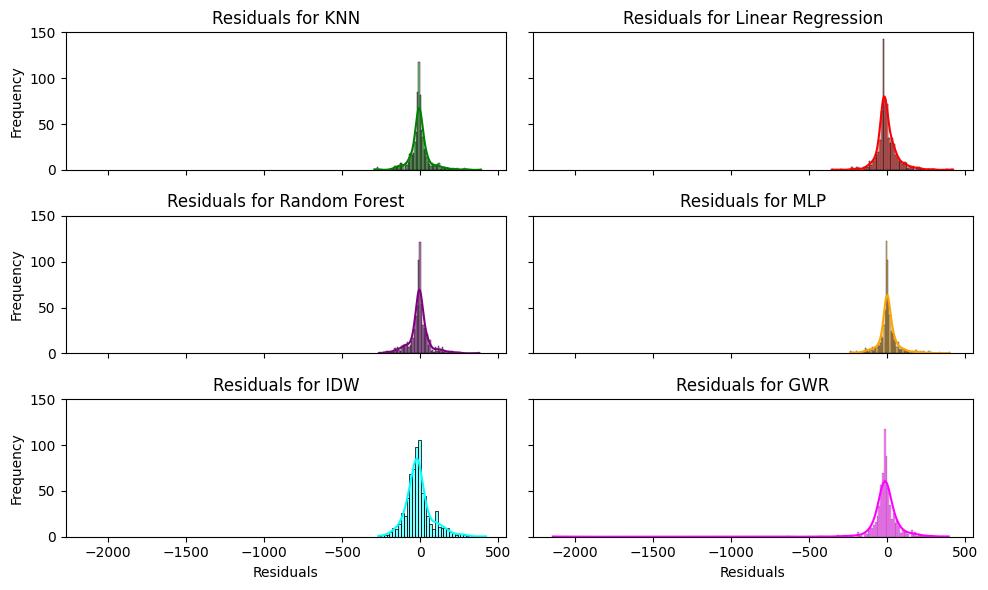

In [41]:
# Calculate residuals for different models
target = 'peakload'
residuals_test_median = test_ESA[target] - test_median_imputed[target]
residuals_test_KNN = test_ESA[target] - test_KNN_df[target]
residuals_test_LR = test_ESA[target] - test_LR.ravel()
residuals_test_RF = test_ESA[target] - test_RF.ravel()
residuals_test_MLP = test_ESA[target] - test_MLP.ravel()
residuals_test_IDW = test_ESA[target] - test_IDW.ravel()
residuals_test_GWR = test_ESA[target] - test_GWR.ravel()

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True, sharey=True)

# KNN
sns.histplot(residuals_test_KNN, kde=True, color='green', ax=axs[0, 0])
axs[0, 0].set_title('Residuals for KNN')
axs[0, 0].set_xlabel('Residuals')
axs[0, 0].set_ylabel('Frequency')

# Linear Regression
sns.histplot(residuals_test_LR, kde=True, color='red', ax=axs[0, 1])
axs[0, 1].set_title('Residuals for Linear Regression')
axs[0, 1].set_xlabel('Residuals')
axs[0, 1].set_ylabel('Frequency')

# Random Forest
sns.histplot(residuals_test_RF, kde=True, color='purple', ax=axs[1, 0])
axs[1, 0].set_title('Residuals for Random Forest')
axs[1, 0].set_xlabel('Residuals')
axs[1, 0].set_ylabel('Frequency')

# MLP
sns.histplot(residuals_test_MLP, kde=True, color='orange', ax=axs[1, 1])
axs[1, 1].set_title('Residuals for MLP')
axs[1, 1].set_xlabel('Residuals')
axs[1, 1].set_ylabel('Frequency')

# IDW
sns.histplot(residuals_test_IDW, kde=True, color='cyan', ax=axs[2, 0])
axs[2, 0].set_title('Residuals for IDW')
axs[2, 0].set_xlabel('Residuals')
axs[2, 0].set_ylabel('Frequency')

# GWR
sns.histplot(residuals_test_GWR, kde=True, color='magenta', ax=axs[2, 1])
axs[2, 1].set_title('Residuals for GWR')
axs[2, 1].set_xlabel('Residuals')
axs[2, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

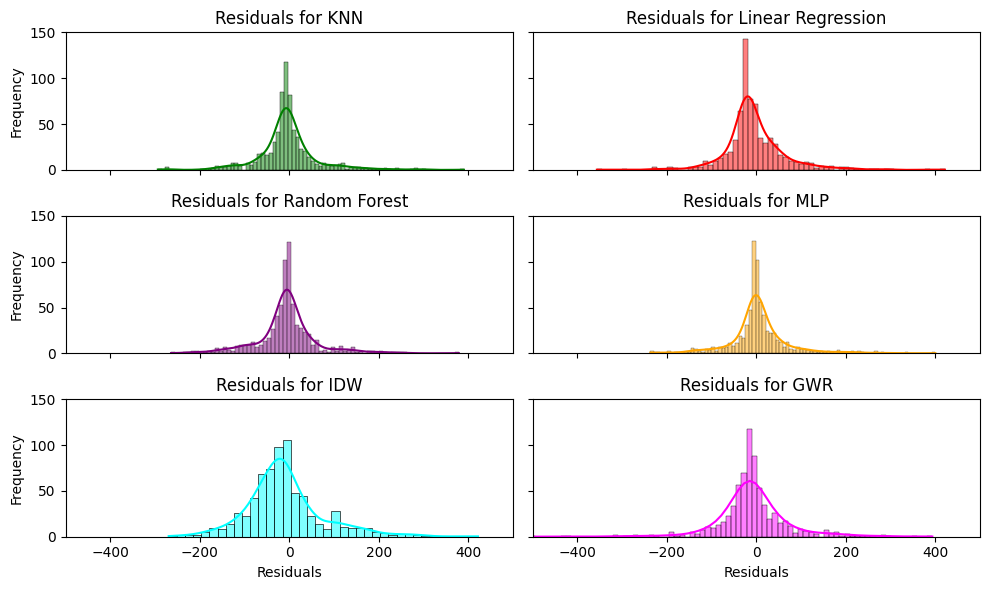

In [42]:
## plots with -500 to 500
# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True, sharey=True)

# KNN
sns.histplot(residuals_test_KNN, kde=True, color='green', ax=axs[0, 0])
axs[0, 0].set_title('Residuals for KNN')
axs[0, 0].set_xlabel('Residuals')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_xlim(-500, 500)

# Linear Regression
sns.histplot(residuals_test_LR, kde=True, color='red', ax=axs[0, 1])
axs[0, 1].set_title('Residuals for Linear Regression')
axs[0, 1].set_xlabel('Residuals')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_xlim(-500, 500)

# Random Forest
sns.histplot(residuals_test_RF, kde=True, color='purple', ax=axs[1, 0])
axs[1, 0].set_title('Residuals for Random Forest')
axs[1, 0].set_xlabel('Residuals')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_xlim(-500, 500)

# MLP
sns.histplot(residuals_test_MLP, kde=True, color='orange', ax=axs[1, 1])
axs[1, 1].set_title('Residuals for MLP')
axs[1, 1].set_xlabel('Residuals')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_xlim(-500, 500)

# IDW
sns.histplot(residuals_test_IDW, kde=True, color='cyan', ax=axs[2, 0])
axs[2, 0].set_title('Residuals for IDW')
axs[2, 0].set_xlabel('Residuals')
axs[2, 0].set_ylabel('Frequency')
axs[2, 0].set_xlim(-500, 500)

# GWR
sns.histplot(residuals_test_GWR, kde=True, color='magenta', ax=axs[2, 1])
axs[2, 1].set_title('Residuals for GWR')
axs[2, 1].set_xlabel('Residuals')
axs[2, 1].set_ylabel('Frequency')
axs[2, 1].set_xlim(-500, 500)

# Adjust layout
plt.tight_layout()
plt.show()